---  
title: "SPICEの使い方に関するノートブック"  
author: "Naoya Ozaki"  
date: "16 October 2021"  
output: "spice_test"  

---  

# SPICEの使い方に関するノートブック

本ノートにNASAジェット推進研究所(JPL)のNavigation and Ancillary Information Facility (NAIF)が提供するSPICE 1)の使い方をまとめる．C,FOTRAN, MATLAB等のインタフェースが提供されているが，ここではPythonインタフェースである`spiceypy` 2)を用いて，惑星の精密な軌道情報を取得する．

1. https://naif.jpl.nasa.gov/naif/
2. https://spiceypy.readthedocs.io/en/main/

## 1. インストール方法

以下のURLのSPICEツールキットを導入し，カーネルを読み込む(Furnishする)ことで動作させることが可能である．

https://naif.jpl.nasa.gov/naif/toolkit.html


Python用インタフェースは以下のURLから非公式に提供されている．PIPであれば，`pip install spiceypy`，condaであれば `conda install -c conda-forge spiceypy`でインストール可能である．

https://github.com/AndrewAnnex/SpiceyPy

## 2. SPICEカーネルを読み込む

以下のURLからSPICEカーネル(Generic Kernel)をダウンロードすることができる．
https://naif.jpl.nasa.gov/naif/data_generic.html

Generic Kernelは以下のようなカテゴリがある．

- (SPK) Ephemerides for planets, satellites, and some comets and asteroids. NOTE: See the information regarding the Horizons Ephemeris System for generating and subsequently downloading up-to-date comet and asteroid SPKs.
- (PCK) Planetary constants kernels, including special binary versions for the earth and the moon
- (LSK) Current leapseconds kernel
- (FK) Special frames kernels associated with the moon
- (SPK), (FK) Topocentric locations (SPK) and reference frame definitions (FK) for some earth stations
- (DSK) Digital Shape Kernels for a few small,irregularly shaped objects
- Star catalogs (PPM, Tycho2 and Hipparcos, in SPICE Type 1 format)



In [4]:
# Import SPICE Toolkit
import spiceypy as spice
import urllib.request

# Download Generic Kernels (naif0012.tls and de440.bsp)
urllib.request.urlretrieve(
    'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls', 
    'data/naif0012.tls'
)
urllib.request.urlretrieve(
    'https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440.bsp',
    'data/de440.bsp'
)

# Furnish SPICE kernels
spice.furnsh('data/naif0012.tls')
spice.furnsh('data/de440.bsp')


## 3. SPICEから軌道情報を取得する

地球(399)中心での月(301)の軌道を描画する．


In [5]:
# UTC時刻をEphemerisTimeで表示する
et0 = spice.str2et('2021/04/06 13:52:32 UTC')

# 地球に対する月の軌道情報をJ2000黄道面基準座標系で表示する
x_moon = spice.spkezr('MOON',et0,'ECLIPJ2000','NONE','EARTH')

et0, x_moon


(670989221.1856551,
 (array([ 2.64278727e+05, -2.80461686e+05, -3.01101254e+04,  7.68807861e-01,
          6.60662120e-01, -4.73643876e-02]),
  1.289339025621054))

In [6]:
import numpy as np

et_all = et0 + np.linspace(0.0, 365*86400, 100000)

x = np.array([spice.spkezr('MOON', et, 'ECLIPJ2000', 'NONE', 'EARTH')[0]
              for et in et_all])


## 4. 軌道の描画

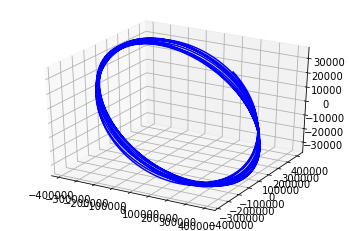

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

# Matplotlibでの描画
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:, 0], x[:, 1], x[:, 2], color='blue')

plt.show()


## 5. 描画にPlotlyを使った場合の結果

In [8]:
import plotly.offline as po
import plotly.graph_objs as go

scale_factor_xy = 5e+5

# Create Trace
trace_traj = go.Scatter3d(
    x=x[:, 0],
    y=x[:, 1],
    z=x[:, 2],
    name='trajectory',
    mode='lines',
    line=dict(
        color='rgba(0,0,0,1)',
        width=2
    )
)

# Create Layout
layout = go.Layout(
    margin=dict({'l': 0, 'r': 0, 'b': 0, 't': 0}),  # Margin 0
    scene=dict({
        'aspectmode': 'manual',
        'aspectratio': {'x': 1, 'y': 1, 'z': 0.75},
        # Disable 'perspective'
        'camera': {'projection': {'type': 'orthographic'}},
        'xaxis': {'range': [-scale_factor_xy, scale_factor_xy],
                  'nticks': 20,
                  'exponentformat': 'e',
                  'backgroundcolor': 'rgba(0,0,0,0)',
                  'gridcolor': 'rgba(1,1,1,0.2)',
                  'title': 'x, km'},
        'yaxis': {'range': [-scale_factor_xy, scale_factor_xy],
                  'nticks': 20,
                  'exponentformat': 'e',
                  'backgroundcolor': 'rgba(0,0,0,0)',
                  'gridcolor': 'rgba(1,1,1,0.2)',
                  'title': 'y, km'},
        'zaxis': {'range': [-0.75*scale_factor_xy, 0.75*scale_factor_xy],
                  'nticks': 10,
                  'exponentformat': 'e',
                  'backgroundcolor': 'rgba(0,0,0,0)',
                  'gridcolor': 'rgba(1,1,1,0.2)',
                  'title': 'z, km'}
    }),
)

# Display
fig = go.Figure(data=trace_traj, layout=layout)
po.iplot(fig, filename='twobody_trajectory')
